In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_05_anneal")' FastaiNotebook_05_anneal

Installing packages:
	.package(path: "/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_05_anneal")
		FastaiNotebook_05_anneal
With SwiftPM flags: []
Working in: /tmp/tmp2kl5o1fg/swift-install
/home/jmd/swift/usr/bin/swift-build: /home/jmd/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jmd/swift/usr/lib/swift/linux/libFoundationNetworking.so)
[1/11] Compiling FastaiNotebook_05_anneal 02a_why_sqrt5.swift
[2/11] Compiling FastaiNotebook_05_anneal 03_minibatch_training.swift
[3/11] Compiling FastaiNotebook_05_anneal 00_load_data.swift
[4/11] Compiling FastaiNotebook_05_anneal 01_matmul.swift
[5/11] Compiling FastaiNotebook_05_anneal 01a_fastai_layers.swift
[6/11] Compiling FastaiNotebook_05_anneal 02_fully_connected.swift
[7/11] Compiling FastaiNotebook_05_anneal 04_callbacks.swift
/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_05_anneal/Sources/FastaiNotebook_05_anneal/04_callbacks.swift:27:25: warning: 'Dataset' is deprecated: Datasets will 

        return innerDs.shuffled(sampleCount: dsCount, randomSeed: seed).batched(bs)
                       ^
/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_05_anneal/Sources/FastaiNotebook_05_anneal/04_callbacks.swift:38:73: warning: 'batched' is deprecated
        return innerDs.shuffled(sampleCount: dsCount, randomSeed: seed).batched(bs)
                                                                        ^
/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_05_anneal/Sources/FastaiNotebook_05_anneal/04_callbacks.swift:58:29: warning: 'Dataset' is deprecated: Datasets will be removed in S4TF v0.10. Please use the new Batches API instead.
    return DataBunch(train: Dataset(elements: DataBatch(xb:xTrain, yb: yTrain)), 
                            ^
/home/jmd/workspace/ml/fastai/nbs/swift/FastaiNotebook_05_anneal/Sources/FastaiNotebook_05_anneal/04_callbacks.swift:59:29: warning: 'Dataset' is deprecated: Datasets will be removed in S4TF v0.10. Please use the new Batches A

In [2]:
//export
import Path
import TensorFlow
#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif


In [3]:
import FastaiNotebook_05_anneal

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [5]:
let data = mnistDataBunch(flat: true)

In [6]:
let (n,m) = (60000,784)
let c = 10
let nHid = 50

In [7]:
func optFunc(_ model: BasicModel) -> SGD<BasicModel> {return SGD(for: model, learningRate: 1e-2)}

In [8]:
func modelInit() -> BasicModel {return BasicModel(nIn: m, nHid: nHid, nOut: c)}

In [9]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeRecorder()

In [10]:
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeShowProgress(),
                     learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                     learner.makeAvgMetric(metrics: [accuracy]), recorder]

In [11]:
learner.fit(2)

Epoch 0: [0.29762614, 0.9157]                                                  
Epoch 1: [0.24082728, 0.9295]                                                  


In [12]:
// export
//TODO: when recorder can be accessed as a property, remove it from the return
extension Learner where Opt.Scalar: PythonConvertible {
    public func makeDefaultDelegates(metrics: [(Output, Label) -> TF] = []) -> Recorder {
        let recorder = makeRecorder()
        delegates = [makeTrainEvalDelegate(), makeShowProgress(), recorder]
        if !metrics.isEmpty { delegates.append(makeAvgMetric(metrics: metrics)) }
        return recorder
    }
}

In [13]:
extension Learner {
    public class TestControlFlow: Delegate {
        public override var order: Int { return 3 }
        
        var skipAfter,stopAfter: Int
        public init(skipAfter:Int, stopAfter: Int){  (self.skipAfter,self.stopAfter) = (skipAfter,stopAfter) }
        
        public override func batchWillStart(learner: Learner) throws {
            print("batchWillStart")
            if learner.currentIter >= stopAfter {
                throw LearnerAction.stop(reason: "*** stopped: \(learner.currentIter)")
            }
            if learner.currentIter >= skipAfter {
                throw LearnerAction.skipBatch(reason: "*** skipBatch: \(learner.currentIter)")
            }
        }
        
        public override func trainingDidFinish(learner: Learner) {
            print("trainingDidFinish")
        }
        
        public override func batchSkipped(learner: Learner, reason: String) {
            print(reason)
        }
    }
}

In [14]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)

In [15]:
learner.delegates = [type(of: learner).TestControlFlow(skipAfter:5, stopAfter: 8),
                     learner.makeTrainEvalDelegate()]

In [16]:
learner.fit(5)

batchWillStart
batchWillStart
batchWillStart
batchWillStart
batchWillStart
batchWillStart
*** skipBatch: 5
batchWillStart
*** skipBatch: 6
batchWillStart
*** skipBatch: 7
batchWillStart
trainingDidFinish


In [17]:
(learner.delegates[0].order,learner.delegates[1].order)

▿ 2 elements
  - .0 : 0
  - .1 : 3


In [18]:
// export
extension Learner where Opt.Scalar: BinaryFloatingPoint {
    public class LRFinder: Delegate {
        public typealias ScheduleFunc = (Float) -> Float

        // A learning rate schedule from step to float.
        private var scheduler: ScheduleFunc
        private var numIter: Int
        private var minLoss: Float? = nil
        
        public init(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) {
            scheduler = makeAnnealer(start: start, end: end, schedule: expSchedule)
            self.numIter = numIter
        }
        
        override public func batchWillStart(learner: Learner) {
            learner.opt.learningRate = Opt.Scalar(scheduler(Float(learner.currentIter)/Float(numIter)))
        }
        
        override public func batchDidFinish(learner: Learner) throws {
            if minLoss == nil {minLoss = learner.currentLoss.scalar}
            else { 
                if learner.currentLoss.scalarized() < minLoss! { minLoss = learner.currentLoss.scalarized()}
                if learner.currentLoss.scalarized() > 4 * minLoss! { 
                    throw LearnerAction.stop(reason: "Loss diverged")
                }
                if learner.currentIter >= numIter { 
                    throw LearnerAction.stop(reason: "Finished the range.") 
                }
            }
        }
        
        override public func validationWillStart(learner: Learner<Label, Opt>) throws {
            //Skip validation during the LR range test
            throw LearnerAction.skipEpoch(reason: "No validation in the LR Finder.")
        }
    }
    
    public func makeLRFinder(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) -> LRFinder {
        return LRFinder(start: start, end: end, numIter: numIter)
    }
}

In [19]:
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates()

In [20]:
learner.delegates.append(learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std))
learner.delegates.append(learner.makeLRFinder())

In [21]:
learner.fit(2)

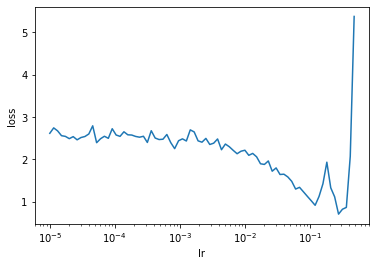

In [22]:
recorder.plotLRFinder()

In [23]:
// export
//TODO: when Recorder is a property of Learner don't return it.
extension Learner where Opt.Scalar: PythonConvertible & BinaryFloatingPoint {
    public func lrFind(start: Float = 1e-5, end: Float = 10, numIter: Int = 100) -> Recorder {
        let epochCount = data.train.count/numIter + 1
        let recorder = makeDefaultDelegates()
        delegates.append(makeLRFinder(start: start, end: end, numIter: numIter))
        try! self.fit(epochCount)
        return recorder
    }
}

In [24]:
let recorder = learner.lrFind()

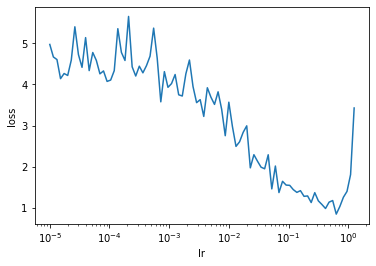

In [25]:
recorder.plotLRFinder()

In [26]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"05b_early_stopping.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
